In [1]:
import pandas as pd 
import numpy as np 
import os
from glob import glob
from PIL import Image
import shutil
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import warnings 
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
warnings.filterwarnings('ignore')


In [3]:
skinDf = pd.read_csv('HAM10000_metadata.csv')

img_size = (224, 224)


In [4]:
labelEncoder = LabelEncoder()
skinDf['label'] = labelEncoder.fit_transform(skinDf['dx'])

dfs_by_label_resampled = {}
n_samples = 800
for label in range(7):
    df_label_resampled = resample(skinDf[skinDf['label'] == label], n_samples=n_samples, replace=True, random_state=42)
    dfs_by_label_resampled[label] = df_label_resampled
balanced_df = pd.concat(dfs_by_label_resampled.values()).sample(frac=1, random_state=42).reset_index(drop=True)


In [5]:
from os import listdir
dir="HAM10000_images_part_1"
dir2="HAM10000_images_part_2"
mapped_path=dict()

for i in listdir(dir):
    if i.endswith(".jpg"):
        str1=i
        str1=str1[:12]
        mapped_path[str1]=dir+'/'+i

for i in listdir(dir2):
    if i.endswith(".jpg"):
        str1=i
        str1=str1[:12]
        mapped_path[str1]=dir2+'/'+i

In [6]:
lesion_name = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [7]:
balanced_df['path']=balanced_df['image_id'].map(mapped_path.get)
balanced_df['cell_type']=balanced_df['dx'].map(lesion_name.get)
balanced_df['cell_type_id']=pd.Categorical(balanced_df['cell_type']).codes

In [8]:
balanced_df['age'].fillna((balanced_df['age'].mean()), inplace=True)

In [9]:
from PIL import Image
balanced_df['image'] = balanced_df['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))


In [10]:
x = np.asarray(balanced_df['image'].to_list())
y = to_categorical(balanced_df['cell_type_id'], num_classes=7)
y = np.asarray(y)

x.shape

(5600, 224, 224, 3)

In [ ]:
# y = np.expand_dims(y, axis=2)
# y = np.expand_dims(y, axis=3)
y.shape

(5600, 7)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42, shuffle=True)

In [13]:
y.shape

(5600, 7)

In [14]:
balanced_df.to_csv('processed_cancer.csv')

In [15]:
x_test.shape

(1120, 224, 224, 3)

In [16]:
import tensorflow as tf
import keras

In [17]:
num_classes=7
dimensions=(224, 224, 3)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images    

Datagen.fit(x_train)

In [19]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [20]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [21]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
# x = preprocess_input(x)

vgg16

In [22]:
model=tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=dimensions,
    classes=num_classes
) 

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Efficientnet

In [23]:
# model=keras.applications.EfficientNetB0(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=dimensions,
#     pooling=None,
#     classes=num_classes,
#     classifier_activation="softmax"
# )

Resnet50

In [24]:
# model = keras.applications.ResNet50(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=dimensions,
#     pooling=None,
#     classes=num_classes,
#     classifier_activation="softmax",
# )

Mobilenet

In [25]:
# model=keras.applications.MobileNet(
#     input_shape=dimensions,
#     alpha=1.0,
#     depth_multiplier=1,
#     dropout=0.001,
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     pooling=None,
#     classes=num_classes,
#     classifier_activation="softmax",
# )

Sequential

In [26]:
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(224, 224, 3)),
#     MaxPooling2D(),
#     BatchNormalization(),
#     Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
#     Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
#     MaxPooling2D(),
#     BatchNormalization(),
#     Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
#     Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
#     MaxPooling2D(),
#     BatchNormalization(),
#     Flatten(),
#     Dropout(rate=0.5),
#     Dense(256, activation='relu', kernel_initializer='he_normal'),
#     Dropout(rate=0.5),
#     Dense(128, activation='relu', kernel_initializer='he_normal'),
#     Dropout(rate=0.5),
#     Dense(32, activation='relu', kernel_initializer='he_normal'),
#     BatchNormalization(),
#     Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier')
# ])
# model.summary()

In [27]:
model.trainable=False

In [28]:
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
i=0
for layer in model.layers:
  i+=1
  layer.trainable=False
print(i)

19


In [29]:
model1=model(x, training=False)
# model1=model.output
# model1 = model.get_layer(index=-1).output
# model1 = GlobalAveragePooling2D(model1)

model1 = Flatten()(model1)
# model1 = Dense(1024, activation="relu")(model1)
# model1 = BatchNormalization()(model1)
# model1 = Dropout(0.5)(model1)
# model1 = Dense(1024, activation="relu")(model1)
# model1 = BatchNormalization()(model1)
# model1 = Dropout(0.5)(model1)
# model1 = Dense(512, activation="relu")(model1)
# model1 = BatchNormalization()(model1)
model1 = Dropout(0.2)(model1)
model2 = Dense(7, activation="softmax")(model1)

modelf=keras.Model(inputs=inputs, outputs=model2)    
modelf.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │       175,623 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,890,311 (56.80 MB)

 Trainable params: 175,623 (686.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [30]:
print(x_train.shape)
print(y_train.shape)

(4480, 224, 224, 3)
(4480, 7)


In [31]:
print(modelf.input.shape)
print(modelf.output.shape)

(None, 224, 224, 3)
(None, 7)


In [32]:
base_learning_rate=0.0001
modelf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=base_learning_rate/10)

In [34]:
initial_epochs=20
history = modelf.fit(x_train, y_train, epochs=initial_epochs, batch_size=8, validation_data=(x_test, y_test), callbacks=[EarlyStopping(patience=5), learning_rate_reduction])


Epoch 1/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 193s 343ms/step - accuracy: 0.3000 - loss: 5.6723 - val_accuracy: 0.4750 - val_loss: 3.7661 - learning_rate: 1.0000e-04
Epoch 2/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 190s 340ms/step - accuracy: 0.5141 - loss: 3.0059 - val_accuracy: 0.5562 - val_loss: 3.1324 - learning_rate: 1.0000e-04
Epoch 3/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 191s 341ms/step - accuracy: 0.5884 - loss: 2.3247 - val_accuracy: 0.5946 - val_loss: 2.5060 - learning_rate: 1.0000e-04
Epoch 4/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 190s 339ms/step - accuracy: 0.6196 - loss: 2.0543 - val_accuracy: 0.6187 - val_loss: 2.3662 - learning_rate: 1.0000e-04
Epoch 5/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 189s 337ms/step - accuracy: 0.6439 - loss: 1.7125 - val_accuracy: 0.6384 - val_loss: 2.1274 - learning_rate: 1.0000e-04
Epoch 6/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 190s 339ms/step - accuracy: 0.6833 - loss: 1.4789 - val_accuracy: 0.6554 - val_loss: 1.9406 - learning_rate: 1.0000e-04
Epoch 7/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 

In [35]:
test_loss, test_accuracy = modelf.evaluate(x_test, y_test)
print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)


35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7305 - loss: 1.7352
Test Accuracy: 0.7196428775787354
Test Loss: 1.8755079507827759


In [45]:
import pickle

h_count=0
pickle_file_name='history_vgg16.pkl'

with open(pickle_file_name, 'wb') as file:
        pickle.dump(history,file)
        h_count+=1

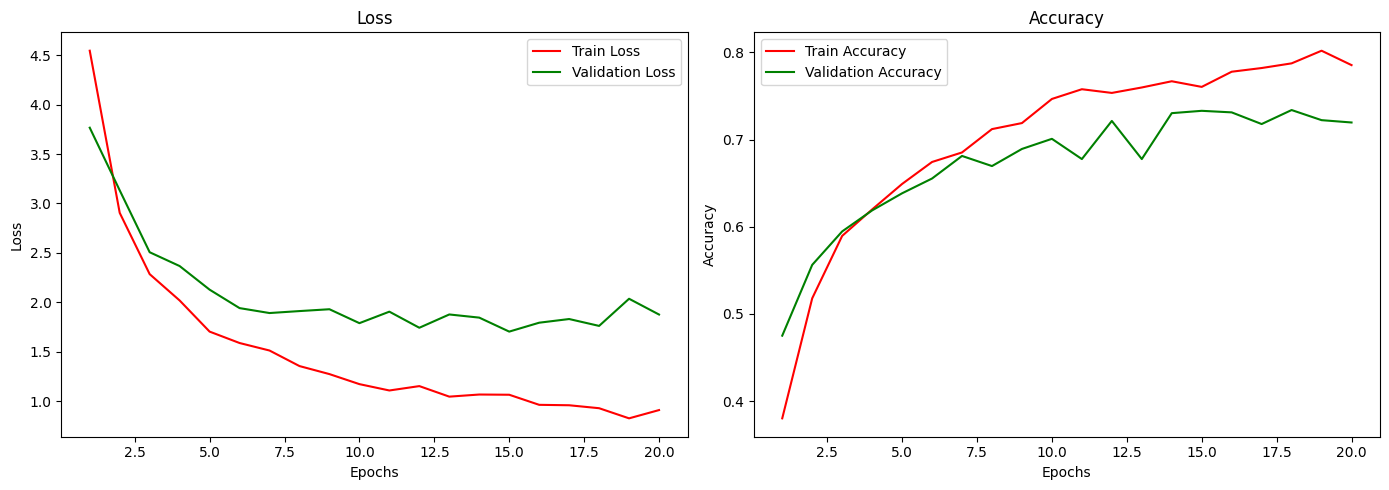

In [36]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
len(modelf.trainable_variables)

2

In [38]:
model.trainable=True

In [39]:
len(modelf.trainable_variables)

28

In [40]:
for layer in model.layers[:i]:
  
  layer.trainable=False
print(i)

19


In [41]:
len(modelf.trainable_variables)

2

In [42]:
base_learning_rate

0.0001

In [43]:
new_learning_rate=base_learning_rate/10
modelf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=new_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'],)

In [44]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=new_learning_rate/10)

In [46]:
with open('history_vgg16.pkl', 'rb') as file:  
    history = pickle.load(file)

In [48]:
type(history)

keras.src.callbacks.history.History

In [47]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = modelf.fit(x_train,y_train,batch_size=8,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=(x_test, y_test),
                         callbacks=[EarlyStopping(patience=5), learning_rate_reduction])

Epoch 21/120
303/560 ━━━━━━━━━━━━━━━━━━━━ 1:13 285ms/step - accuracy: 0.8182 - loss: 0.7492

KeyboardInterrupt: 

In [145]:
test_loss, test_accuracy = modelf.evaluate(x_test, y_test)
print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)


35/35 ━━━━━━━━━━━━━━━━━━━━ 166s 5s/step - accuracy: 0.7823 - loss: 1.1836
Test Accuracy: 0.7642857432365417
Test Loss: 1.3563553094863892


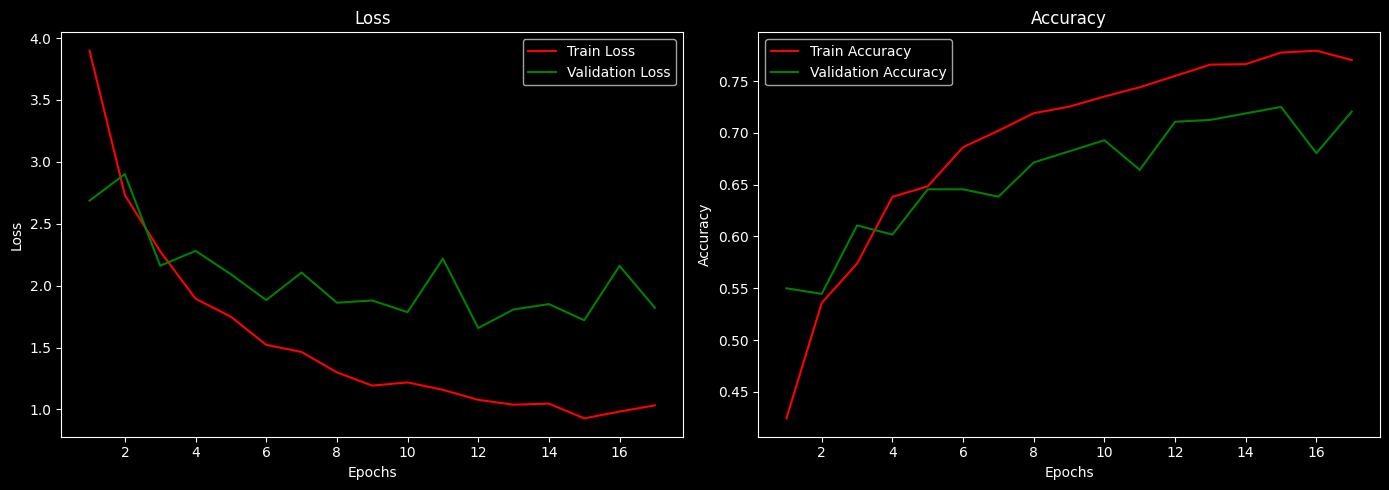

In [146]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [147]:
y_pred=modelf.predict(x_test)
y_pred[0]

35/35 ━━━━━━━━━━━━━━━━━━━━ 168s 5s/step


array([3.8866987e-04, 2.3084667e-03, 3.6666982e-02, 5.8448239e-11,
       1.3491459e-04, 9.6050096e-01, 7.6760312e-16], dtype=float32)

In [148]:
y_pred_classes=np.argmax(y_pred,axis=1)
y_pred_classes

array([5, 2, 2, ..., 5, 3, 5])

In [149]:
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [150]:
y_test_classes=np.argmax(y_test, axis=1)
y_test_classes

array([5, 2, 0, ..., 5, 3, 5])

In [151]:
df_test=pd.DataFrame()
df_test['Y_pred']=y_pred_classes
# df_test['Y_pred_classes']=y_pred_classes
df_test['Y_true']=y_test_classes



In [152]:
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

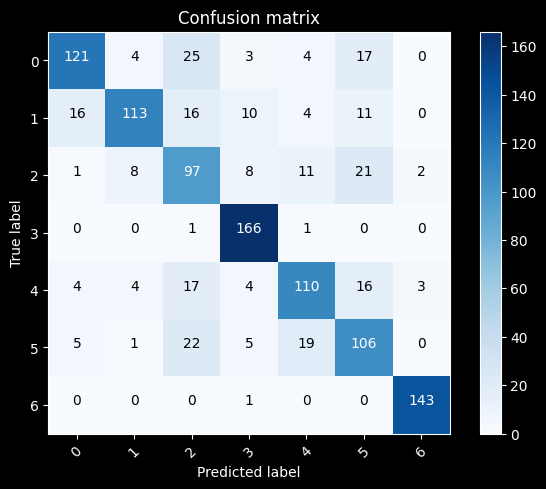

In [153]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 



In [154]:
list=['class 0','class 1','class 2','class 3','class 4','class 5','class 6']

In [155]:
y_test_classes

array([5, 2, 0, ..., 5, 3, 5])

In [156]:
from sklearn.metrics import classification_report

report= classification_report(y_test_classes, y_pred_classes, target_names=list)    
print(report)

              precision    recall  f1-score   support

     class 0       0.82      0.70      0.75       174
     class 1       0.87      0.66      0.75       170
     class 2       0.54      0.66      0.60       148
     class 3       0.84      0.99      0.91       168
     class 4       0.74      0.70      0.72       158
     class 5       0.62      0.67      0.64       158
     class 6       0.97      0.99      0.98       144

    accuracy                           0.76      1120
   macro avg       0.77      0.77      0.76      1120
weighted avg       0.77      0.76      0.76      1120



In [157]:
import pickle

pickle_file_name='cancer_vgg16_.pkl'

with open(pickle_file_name, 'wb') as file:
        pickle.dump(modelf,file)